## import the libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import uproot3
import dask.dataframe as dd
import time
from dask import delayed
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
import os

pd.pandas.set_option('display.max_columns',None)

## Check if jupyter notebook or script

In [3]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [4]:
if in_ipynb():
    print("In IPython")
    TrainConfig="Configs/MultiClassification_XGBoost_barrel"
    exec("import "+TrainConfig.replace("/", ".")+" as Conf")
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

{'IPKernelApp': {'connection_file': '/scratch/rchudasa/.local/share/jupyter/runtime/kernel-989030b0-8173-49ae-9966-b93bd7b31bc8.json'}, 'InteractiveShellApp': {'extensions': <LazyConfigValue value=['sparkmonitor.kernelextension', 'swankernelenv']>}}
In IPython


2022-11-10 15:55:07.946648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

### Function to return pandas dataframe from root file 

In [5]:
def get_pandasDataFrame(process,cat,path,fileName,treeName,branches,selection,fraction):
    print(selection)
    eventsPhoton  = uproot3.open(path+fileName)[treeName]
    #pd_dataframe  = eventsPhoton.pandas.df(branches=branches)
    pd_dataframe  = eventsPhoton.pandas.df(branches=branches).query(selection)
    pd_dataframe['Class'] = process
    pd_dataframe['Category'] = cat
    pd_dataframe = pd_dataframe.sample(frac=fraction)
    
    print(pd_dataframe.shape)
    return pd_dataframe

 
def MyBins(lower,upper,step): return np.arange(lower,upper,step).tolist() 

def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]

    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)


## Define MVA parameters as a dictionary 

In [6]:
import pickle
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns

In [7]:
MVA = {"MVAtype":"XGB_1", #Keyword to identify MVA method.
     "Color":"green", #Plot color for MVA
     "Label":"XGB small list", # label can be anything (this is how you will identify them on plot legends)
     "features":['scEtaWidth','scR9','scSigmaIetaIeta','scSigmaIetaIphi','scEMaxRatio','scSwissCross','scE2x5_MaxRatio','scE2ndRatio','scPFChIso1','scPFChIso3','scPFChIso5'],
     "feature_bins":[MyBins(0,0.1,0.001), MyBins(0,1,0.01), MyBins(0,0.1,0.001),MyBins(0,0.002,0.00001),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01), 
                    MyBins(0,100,1),MyBins(0,100,1),MyBins(0,100,1)], #same length as features #Binning used only for plotting features (should be in the same order as features), 
     'Scaler':"StandardScaler", #Scaling for features before passing to the model training
     'UseGPU':False, #If you have a GPU card, you can turn on this option (CUDA 10.0, Compute Capability 3.5 required)
     "XGBGridSearch":{'colsample_bytree': [0.5,1.0], 'gamma': [0.5], 'max_depth': [5,3], 'min_child_weight': [5], 'subsample': [0.8]}
      }

#os.system("mkdir -p " + Conf.OutputDirName+"/"+MVA["MVAtype"])

## Loading the test/train dataset :  CHECK IF THIS PROVIDES A DETERMINSTIC SET OF TEST/TRAIN

In [8]:
Classes=Conf.Classes
print(Classes)

['Signal', 'QCD', 'Pi0', 'Data']


In [9]:
print(Conf.OutputDirName)

MultiClassification_XGBoost_barrel_balance_dataset


In [10]:
dfs= []
start = time.time()
for process in Conf.processes:
    path = Conf.baseInputPath
    pr = process['Class']
    cat = process['category']
    fileName  = process['fileName']
    treeName  = process['treeName']
    selection = process['selection']
    fraction  = process['fraction']
    print(path,fileName,treeName,fraction)
    dfs.append(delayed(get_pandasDataFrame(pr,cat,path,fileName,treeName,branches=Conf.branches,selection=selection,fraction=fraction)))
end  = time.time()
print("Execution time is", end-start)

/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_signal_bsMMG_barrel.root genMatchedBMMGSCTree 0.3
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(54040, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_qcd20To30EmEnriched_barrel.root mergedPi0_SCTree 1
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(64661, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_bkg_flat_pi0_barrel.root mergedPi0_SCTree 1
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(49507, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ data_2018D_barrel.root dataAllSCTree 0.1
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(54344, 26)
Execution time is 3.064720392227173


In [11]:
daskframe = dd.from_delayed(dfs)
final_df = daskframe.compute()
final_df.reset_index(inplace=True, drop=True)


final_df["NewWt"]=1
final_df["xsecwt"]=1


index = final_df.index
from sklearn.model_selection import train_test_split
TrainIndices=[]
TestIndices=[]
for myclass in Classes:
    condition = final_df["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=0.25, random_state=42, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

final_df.loc[TrainIndices,'Dataset'] = "Train"
final_df.loc[TestIndices,'Dataset'] = "Test"

final_df.loc[TrainIndices,'TrainDataset'] = 1
final_df.loc[TestIndices,'TrainDataset'] = 0

In [12]:
X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(final_df,TrainIndices,TestIndices,MVA["features"],cat='Category',weight="NewWt")
#exec("from sklearn.preprocessing import "+MVA["Scaler"])
#exec("sc = "+MVA["Scaler"]+"()")
#scale the training data input features so that it is between 0 and 1
#X_train = sc.fit_transform(X_train) 
#X_test = sc.transform(X_test)
# pickle.dump(sc, open(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"_scaler.pkl",'wb'))

## Load the trained Model

In [13]:
import xgboost as xgb
import pickle
from sklearn.model_selection import cross_val_score, GridSearchCV

In [14]:
modelPath=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelXGB.pkl"
scalerPath=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"_scaler.pkl"

#modelPath="MultiClassification_XGBoost_barrelv2/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelXGB.pkl"
#scalerPath="MultiClassification_XGBoost_barrelv2/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"_scaler.pkl"

rslt=None
scaler=None
with open(modelPath, 'rb') as f:
    rslt = pickle.load(f)
with open(scalerPath, 'rb') as f:
    scaler = pickle.load(f)
    
cv=rslt

start = time.time()
xgb_model = cv.best_estimator_


In [15]:
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

In [16]:
'''y_test_pred=xgb_model.predict(X_test)
y_test_pred_df = pd.DataFrame({"actual":Y_test, "predicted":y_test_pred})
y_test_pred_proba=xgb_model.predict_proba(X_test)
y_test_pred_df['predicted_porb']=y_test_pred_proba.tolist()
from tensorflow.keras.utils import to_categorical
Y_test_cat = to_categorical(Y_test,num_classes=4)'''

'y_test_pred=xgb_model.predict(X_test)\ny_test_pred_df = pd.DataFrame({"actual":Y_test, "predicted":y_test_pred})\ny_test_pred_proba=xgb_model.predict_proba(X_test)\ny_test_pred_df[\'predicted_porb\']=y_test_pred_proba.tolist()\nfrom tensorflow.keras.utils import to_categorical\nY_test_cat = to_categorical(Y_test,num_classes=4)'

In [17]:
from tensorflow.keras.utils import to_categorical
y_test_pred=cv.predict_proba(X_test)
y_train_pred=cv.predict_proba(X_train)

Y_train_cat = to_categorical(Y_train, num_classes=4)
Y_test_cat = to_categorical(Y_test, num_classes=4)

In [18]:
final_df.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,0]
final_df.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,0]

In [19]:
plotwt_train=np.asarray(final_df.loc[TrainIndices,'xsecwt'])
plotwt_test=np.asarray(final_df.loc[TestIndices,'xsecwt'])

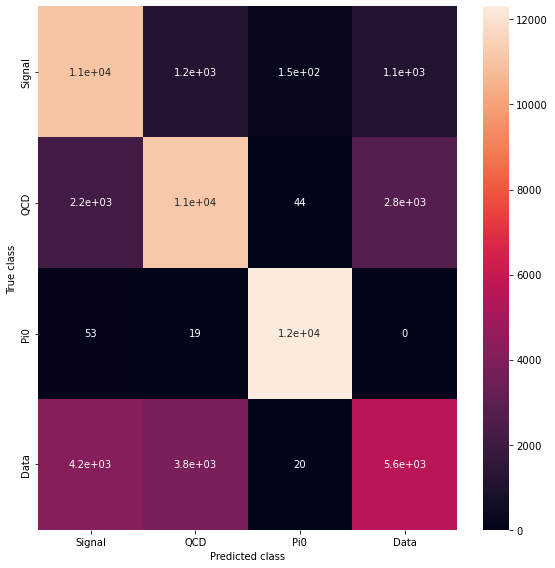

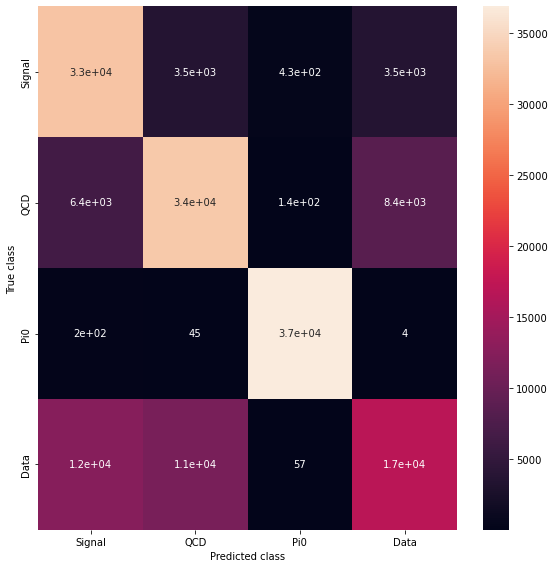

In [20]:
import pandas as pd

from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_test_cat.argmax(axis=1), y_test_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes, columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")

fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_train_cat.argmax(axis=1), y_train_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes,columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")
fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"CM_Training.png") 

In [21]:
'''import seaborn as sns
from sklearn import metrics
def draw_cm( actual, predicted ):
    ## Cret
    fig, axes = plt.subplots(1, 1, figsize=(10,10))
    cm = metrics.confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True)
    axes.set_ylabel("True class")
    axes.set_xlabel("Predicted class")
    plt.show()
draw_cm(Y_test_cat.argmax(axis=1),y_test_pred_proba.argmax(axis=1))
print( metrics.classification_report(y_test_pred_df['actual'],y_test_pred_df['predicted']))'''

'import seaborn as sns\nfrom sklearn import metrics\ndef draw_cm( actual, predicted ):\n    ## Cret\n    fig, axes = plt.subplots(1, 1, figsize=(10,10))\n    cm = metrics.confusion_matrix( actual, predicted)\n    sns.heatmap(cm, annot=True)\n    axes.set_ylabel("True class")\n    axes.set_xlabel("Predicted class")\n    plt.show()\ndraw_cm(Y_test_cat.argmax(axis=1),y_test_pred_proba.argmax(axis=1))\nprint( metrics.classification_report(y_test_pred_df[\'actual\'],y_test_pred_df[\'predicted\']))'

In [22]:
ClassColors=Conf.ClassColors

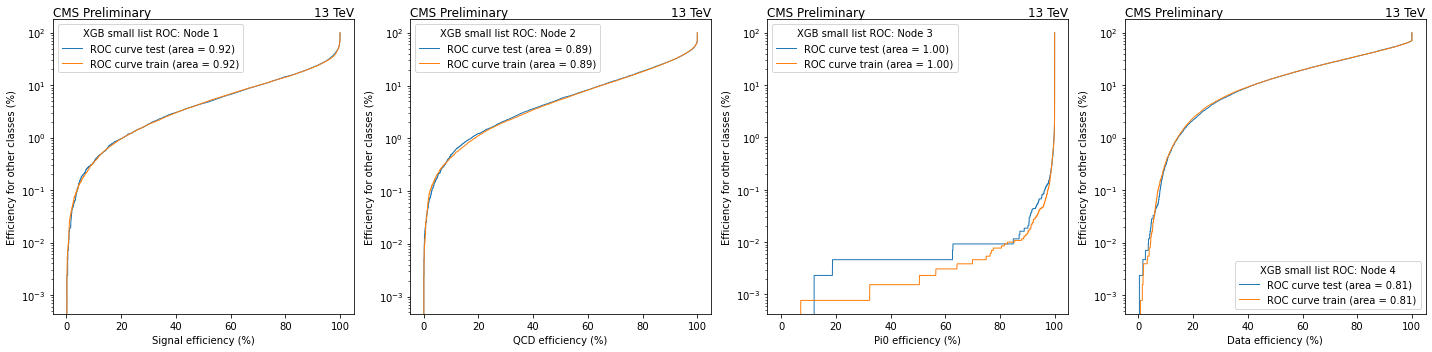

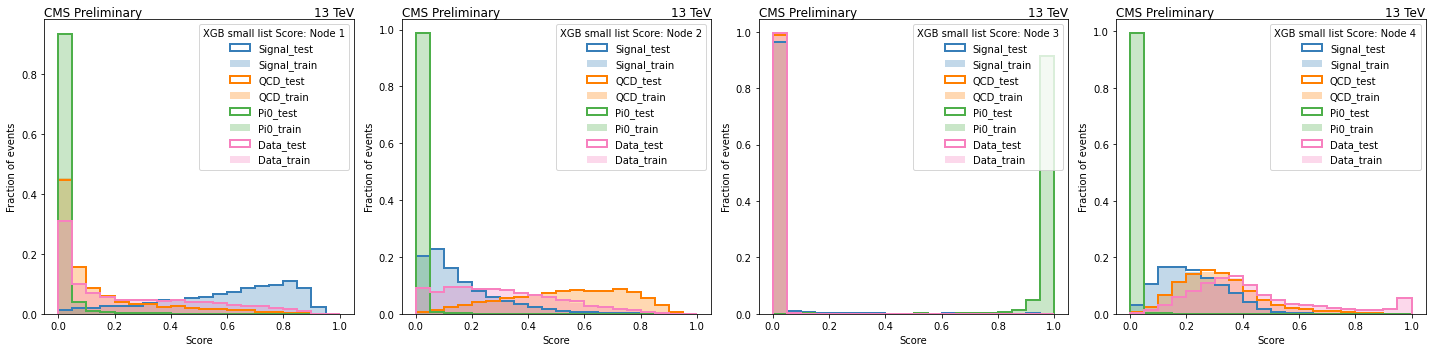

In [23]:
from sklearn.metrics import roc_curve, auc

n_classes=len(Classes)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))    
for i in range(n_classes):
    axMVA=axesMVA[i]
    ax=axes[i]
    for k in range(n_classes):
        axMVA.hist(y_test_pred[:, i][Y_test_cat[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_test',
                   weights=plotwt_test[Y_test_cat[:, k]==1]/np.sum(plotwt_test[Y_test_cat[:, k]==1]),
                   histtype='step',linewidth=2,color=ClassColors[k])
        axMVA.hist(y_train_pred[:, i][Y_train_cat[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_train',
                   weights=plotwt_train[Y_train_cat[:, k]==1]/np.sum(plotwt_train[Y_train_cat[:, k]==1]),
                   histtype='stepfilled',alpha=0.3,linewidth=2,color=ClassColors[k])
        
    axMVA.set_xlabel('Score',fontsize=10)
        
    axMVA.set_ylabel('Fraction of events',fontsize=10)
    axMVA.legend(title=MVA["Label"]+' Score: Node '+str(i+1), loc="best",fontsize=10)
    axMVA.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
        
    axMVA.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
    #axMVA.set_yscale('log')
            
    fpr, tpr, th = roc_curve(Y_test_cat[:, i], y_test_pred[:, i],sample_weight=plotwt_test)
    fpr_tr, tpr_tr, th_tr = roc_curve(Y_train_cat[:, i], y_train_pred[:, i],sample_weight=plotwt_train)
    mask = tpr > 0.0
    fpr, tpr = fpr[mask], tpr[mask]

    mask = tpr_tr > 0.0
    fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

    roc_auc = auc(fpr, tpr)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
            
    ax.plot(tpr*100, fpr*100, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
    ax.plot(tpr_tr*100, fpr_tr*100, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
    ax.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 12)#, fontweight = 'bold')
    ax.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 12)
    ax.set_yscale("log")
    ax.set_xlabel(Classes[i]+' efficiency (%)',fontsize=10)
    ax.set_ylabel('Efficiency for other classes (%)',fontsize=10)
    ax.legend(title=MVA["Label"]+' ROC: Node '+str(i+1),loc="best",fontsize=10)

fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"ROC.pdf")
fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"ROC.png")
figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"MVA.pdf")
figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"MVA.png")

In [24]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, th = roc_curve(Y_test_cat[:, 0], y_test_pred[:, 0],sample_weight=plotwt_test)
mask = tpr > 0.0
fpr, tpr = fpr[mask], tpr[mask]

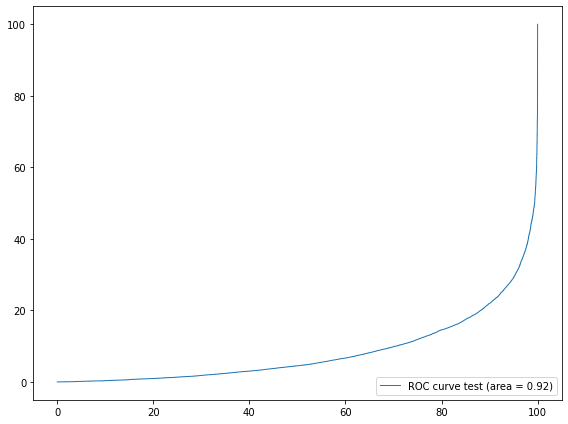

In [25]:
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
# Plot the fpr and tpr values for different threshold values
# draw a diagonal line connecting the origin and top right most point
plt.plot(tpr*100, fpr*100, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
#plt.plot([0, 1], [0, 1], 'k--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
# Setting x and y labels
#plt.xlabel(‘False Positive Rate or [1 - True Negative Rate]’)
#plt.ylabel(‘True Positive Rate’)
plt.legend(loc='lower right')
plt.show()

In [26]:
Conf.OutputDirName

'MultiClassification_XGBoost_barrel_balance_dataset'

## Load the Datsets separtely

In [27]:
baseBath='/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/'
processesToLoad = [
    {'Class':'Evaluation','fileName':'mc_signal_bsJpsiGamma_barrel.root', 
    'treeName':'genMatchedBMMGSCTree', 'selection':'(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)', 'process':'bsMMG', 'category':0},
    {'Class':'Pi0','fileName':'mc_bkg_flat_pi0_barrel.root',
    'treeName':'mergedPi0_SCTree', 'selection':'(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)', 'process':'Flat_pi0','category':2}, 
]

In [28]:
dfs_p2= {}
start = time.time()
for process in processesToLoad:
    path = baseBath
    pr = process['Class']
    cat = process['category']
    fileName  = process['fileName']
    treeName  = process['treeName']
    selection = process['selection']
    print(path,fileName,treeName)
    dfs_p2[process['Class']]=delayed(get_pandasDataFrame(pr,cat,path,fileName,treeName,branches=Conf.branches,selection=selection,fraction=1)).compute()
#     dfs_p2[process['Class']].reset_index(inplace=True, drop=True)
    print(dfs_p2[process['Class']].shape)

end  = time.time()
print("Execution time is", end-start)

/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_signal_bsJpsiGamma_barrel.root genMatchedBMMGSCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(115289, 26)
(115289, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_bkg_flat_pi0_barrel.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(49507, 26)
(49507, 26)
Execution time is 0.8559699058532715


### Make the Tranformed datset ready to be fed to the model

In [29]:
dataset={}
for process in dfs_p2:
    _x=np.asarray(dfs_p2[process][MVA['features']])
    dataset[process]={}
    dataset[process]['X']=scaler.transform(_x)
    

In [30]:
y_bs2JPsi_proba=xgb_model.predict_proba(dataset['Evaluation']['X'])

#### Ploting the score for the Signal

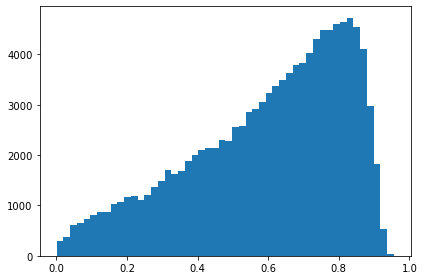

In [31]:
# 0 is for the signal class
_=plt.hist(y_bs2JPsi_proba[:,0],bins=50)

In [32]:
y_bs2JPsi_proba

array([[0.84683776, 0.03249075, 0.00262005, 0.11805141],
       [0.68649423, 0.1279947 , 0.00136332, 0.18414778],
       [0.5323907 , 0.15510245, 0.00163569, 0.31087112],
       ...,
       [0.45028403, 0.19010174, 0.00142599, 0.35818818],
       [0.47335827, 0.18364248, 0.00161239, 0.3413869 ],
       [0.67994845, 0.10119832, 0.00105858, 0.21779464]], dtype=float32)

### Measuring the Accuracy

In [33]:
yPred=np.argmax(y_bs2JPsi_proba,axis=1)
accuracy=sum(yPred==0)/len(yPred)
print("Accuracy : ",accuracy)

Accuracy :  0.8198440440978758


### Overtraining check

    To be done wrt.e train samples used for the Model derivation

In [34]:
# Getting the predictions for test/train sets | note this has to be done in the exact training set # to loaded exactly as in the training step

In [35]:
yPredProba_test=xgb_model.predict_proba(X_test)
yPredProba_train=xgb_model.predict_proba(X_train)

In [36]:
yPredProba_train

array([[0.4436999 , 0.28347227, 0.00137024, 0.27145755],
       [0.7066282 , 0.09610136, 0.00113736, 0.19613306],
       [0.5348728 , 0.21464245, 0.00111909, 0.24936563],
       ...,
       [0.7915767 , 0.04103477, 0.00093202, 0.1664565 ],
       [0.28737   , 0.41076764, 0.00294844, 0.2989139 ],
       [0.813595  , 0.03342113, 0.00090308, 0.15208076]], dtype=float32)

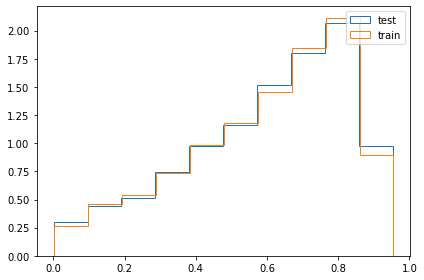

In [39]:
cId=0
classMask_test= Y_test==cId
classMask_train= Y_train==cId

_=plt.hist(yPredProba_test[classMask_test][:,cId]  ,label='test' ,histtype='step',density=True)
_=plt.hist(yPredProba_train[classMask_train][:,cId],label='train',histtype='step',density=True)

#_=plt.hist(yPredProba_test[Y_test][:,0]  ,label='test' ,histtype='step',density=True)
#_=plt.hist(yPredProba_train[Y_train][:,0],label='train',histtype='step',density=True)

plt.legend()

## Efficiencies

In [40]:
import math
from uncertainties import ufloat
from uncertainties.umath import *

In [41]:
def eff(group_df,var,cat,catvalue):
    signalpass=len(group_df.query('('+var+' == 1) & ('+cat+' == '+str(catvalue)+')'))
    signalpass=ufloat(signalpass,math.sqrt(signalpass))
    signaltotal=len(group_df.query('('+cat+' == '+str(catvalue)+')'))
    signaltoal=ufloat(signaltotal,math.sqrt(signaltotal))
    if signaltotal>0:
        signaleff=(100*signalpass)/(signaltotal)
        return [signaleff.n, signaleff.s]
    else:
        print("Some bins have zero signal: assigning zero eff")
        return [0, 0]

def EffTrend(cat='',var='',groupbyvar='',ptbins=[],label='',title='',plotname='',df=pd.DataFrame(),plot_dir='',Classes=[''],Colors=['']):
    figMVAComp, axesComp = plt.subplots(1,1, figsize=(4, 4))
    ax=axesComp
    fulllist=[[] for i in range(len(Classes))]
    fullliste=[[[] for i in range(2)] for i in range(len(Classes))]
    #ptbinsmy=ptbins[:-1]
    ptbinsmy=[(ptbins[m+1]+ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        ptbinsmy[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*1.2
    #ptbinsmy.append(ptbins[len(ptbins)-1]*1.2)
    xefulllist=[(ptbins[m+1]-ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        xefulllist[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*0.2
    for i,group_df in df.groupby(groupbyvar):
        for k in range(len(Classes)):
            val=eff(group_df,var,cat,k)[0]
            vale=eff(group_df,var,cat,k)[1]
            fulllist[k].append(val)
            fullliste[k][0].append(vale)
            if val+vale<100:
                fullliste[k][1].append(vale)
            else:
                fullliste[k][1].append(100-val)
                
        
    for m in range(len(Classes)):
        if len(Classes)>2:
            if m==0 or m==1:
                marker='S'
            else:
                marker='B'
        if len(Classes)<3:
            if m==1:
                marker='S'
            else:
                marker='B'
        ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
    ax.set_ylim(0,130)
    if groupbyvar=='ele_pt_bin':
        #ax.set_yscale('log')
        ax.set_xlim(ptbins[0],ptbins[len(ptbins)-2]*1.4)
    #if groupbyvar=='ele_eta_bin':
        #ax.set_xlim(ptbins[0]*1.2,ptbins[len(ptbins)-1])
    ax.set_xlabel(label)
    ax.set_ylabel("Efficiency (%)")
    ax.set_title(title)
    ax.grid(True)
    #ax.legend(loc='best',ncol=2,bbox_to_anchor=(0., 1.1, 1., 0.2),fontsize=8)
    ax.legend(loc='best',ncol=2,fontsize=10)
    #figMVAComp.savefig(plot_dir+plotname+".pdf")
    #figMVAComp.savefig(plot_dir+plotname+".png")

In [42]:
SigEffWPsi=["80%", "90%"]
MVAs=[MVA]
#ptbins = [4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,12,15]
#etabins = [-2.4,-2.2,-2.0,-1.8,-1.566,1.566,1.8,2.0,2.2,2.4]
#etabins = [-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442]
ptbins = Conf.ptbins
etabins = Conf.etabins
ptwtvar='scEt'
etawtvar='scEta'

In [43]:
cat='Category'

In [46]:
type(dfs_p2)

dict

In [49]:
dfs_p2.keys()

dict_keys(['Evaluation', 'Pi0'])

In [53]:
dataset['Evaluation']

{'X': array([[-0.46200491,  0.96831803,  0.17492844, ..., -0.44583743,
         -0.58814924, -0.55299265],
        [ 1.4470535 ,  0.55664552, -0.12434429, ..., -0.17187635,
         -0.38127601, -0.43383091],
        [-0.24384947, -0.07721637,  0.25961075, ..., -0.44583743,
         -0.45608616, -0.26833429],
        ...,
        [-0.71300207, -0.25700295,  0.34269384, ..., -0.44583743,
         -0.32076847,  0.25412164],
        [-1.21084174, -0.05710095, -1.90190846, ..., -0.44583743,
         -0.34242678, -0.28658988],
        [-0.26310937,  0.96831803,  0.39405007, ..., -0.44583743,
         -0.2604661 , -0.07805147]])}

In [ ]:
if len(SigEffWPsi)>0:
    PredMVAs=[]
    for MVA in MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
    SigEffWPs=SigEffWPsi[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

    for MVA in MVAs:

        final_df["ele_pt_bin"] = pd.cut(final_df[ptwtvar], bins=ptbins, labels=list(range(len(ptbins)-1)))
        final_df["ele_eta_bin"] = pd.cut(final_df[etawtvar], bins=etabins, labels=list(range(len(etabins)-1)))

        EB_train=final_df.loc[TrainIndices]
        EB_test=final_df.loc[TestIndices]
        
        if len(Classes) > 2:
            
            mydftest=EB_test.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Classes,Colors=ClassColors)
            
        if len(Classes) < 3:
            
            mydftest=EB_test.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[ptbins,etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        #Wps=OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
           
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)

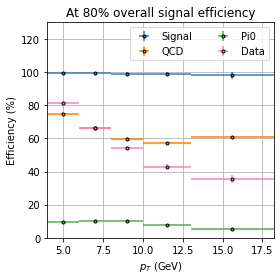

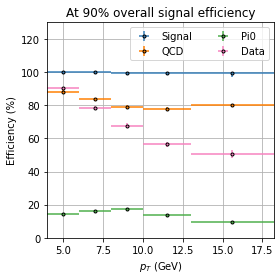

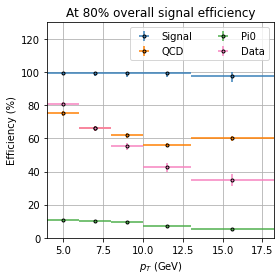

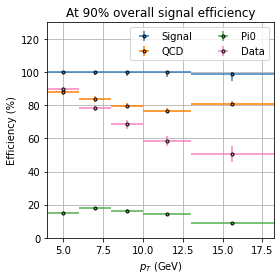

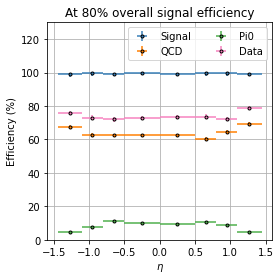

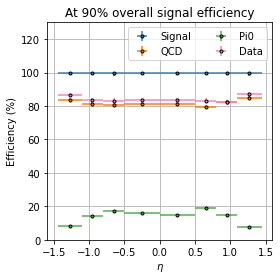

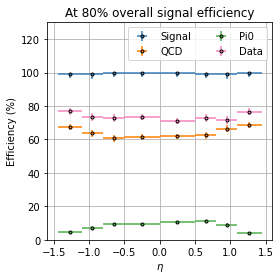

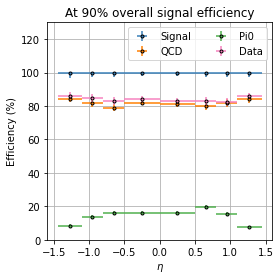

In [55]:
if len(SigEffWPsi)>0:
    PredMVAs=[]
    for MVA in MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
    SigEffWPs=SigEffWPsi[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

    for MVA in MVAs:

        final_df["ele_pt_bin"] = pd.cut(final_df[ptwtvar], bins=ptbins, labels=list(range(len(ptbins)-1)))
        final_df["ele_eta_bin"] = pd.cut(final_df[etawtvar], bins=etabins, labels=list(range(len(etabins)-1)))

        EB_train=final_df.loc[TrainIndices]
        EB_test=final_df.loc[TestIndices]
        
        if len(Classes) > 2:
            
            mydftrain=EB_train.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Classes,Colors=ClassColors)
            
        if len(Classes) < 3:
            
            mydftrain=EB_train.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[ptbins,etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        #Wps=OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)

In [56]:
dfs_p2['Evaluation'][MVA["MVAtype"]+"_pred"]=xgb_model.predict_proba(dataset['Evaluation']['X'])[:,0]
dfs_p2['Pi0'][MVA["MVAtype"]+"_pred"]=xgb_model.predict_proba(dataset['Pi0']['X'])[:,0]

In [57]:
eff_df = pd.concat([dfs_p2['Evaluation'],dfs_p2['Pi0']])

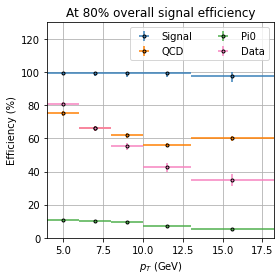

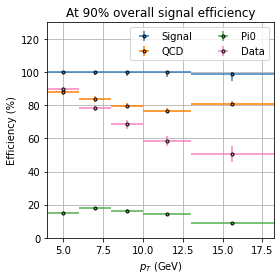

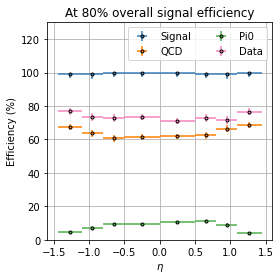

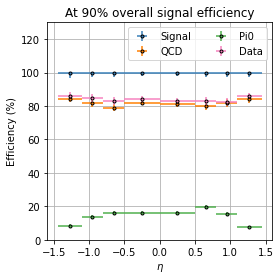

In [58]:
if len(SigEffWPsi)>0:
    PredMVAs=[]
    for MVA in MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
    SigEffWPs=SigEffWPsi[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

    for MVA in MVAs:

        eff_df["ele_pt_bin"] = pd.cut(eff_df[ptwtvar], bins=ptbins, labels=list(range(len(ptbins)-1)))
        eff_df["ele_eta_bin"] = pd.cut(eff_df[etawtvar], bins=etabins, labels=list(range(len(etabins)-1)))

    
        if len(Classes) > 2:
            
            mydftest=eff_df.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Classes,Colors=ClassColors)
            
        if len(Classes) < 3:
            
            mydftest=eff_df.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)

        eff_df.loc[eff_df[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        eff_df.loc[eff_df[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        eff_df.loc[eff_df[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        eff_df.loc[eff_df[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[ptbins,etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        #Wps=OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
           
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)